# Classifying Medical Text

## Preparations

### Import libraries

In [2]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

import re
from collections import Counter

from transformers import AutoTokenizer, AutoModelForSequenceClassification

### Download dataset

In [3]:
medquad_df = pd.read_csv('datasets/medquad.csv')
medquad_df.head()

,question,answer,source,focus_area
0,What is (are) Glaucoma ?,Glaucoma is a group of diseases that can damag...,NIHSeniorHealth,Glaucoma
1,What causes Glaucoma ?,"Nearly 2.7 million people have glaucoma, a lea...",NIHSeniorHealth,Glaucoma
2,What are the symptoms of Glaucoma ?,Symptoms of Glaucoma Glaucoma can develop in ...,NIHSeniorHealth,Glaucoma
3,What are the treatments for Glaucoma ?,"Although open-angle glaucoma cannot be cured, ...",NIHSeniorHealth,Glaucoma
4,What is (are) Glaucoma ?,Glaucoma is a group of diseases that can damag...,NIHSeniorHealth,Glaucoma


In [4]:
medquad_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16412 entries, 0 to 16411
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   question    16412 non-null  object
 1   answer      16407 non-null  object
 2   source      16412 non-null  object
 3   focus_area  16398 non-null  object
dtypes: object(4)
memory usage: 513.0+ KB


In [5]:
medquad_df['focus_area'].nunique()

5126

In [6]:
medquad_df['focus_area'].value_counts()[:25]

focus_area
Breast Cancer                       53
Prostate Cancer                     43
Stroke                              35
Skin Cancer                         34
Alzheimer's Disease                 30
Colorectal Cancer                   29
Lung Cancer                         29
Causes of Diabetes                  28
Heart Failure                       28
High Blood Cholesterol              28
Heart Attack                        28
High Blood Pressure                 27
Parkinson's Disease                 25
Leukemia                            22
Shingles                            21
Osteoporosis                        21
Age-related Macular Degeneration    20
Diabetes                            20
Hemochromatosis                     20
Diabetic Retinopathy                19
Psoriasis                           19
Gum (Periodontal) Disease           19
Kidney Disease                      17
Dry Mouth                           16
Balance Problems                    16
Name: count, d

### Data Cleaning and Preparation

#### Decrease Target Classes Amount

We group the top 25 most common focus areas into 5 groups to not classify 5126 classes.

In [7]:
# Group the top 25 most common focus areas into 5 broader categories (focus groups)
focus_area_map = {
    'Cancers': ['Breast Cancer', 'Prostate Cancer', 'Skin Cancer', 
                'Colorectal Cancer', 'Lung Cancer', 'Leukemia'],
    
    'Cardiovascular Diseases': ['Stroke', 'Heart Failure', 'Heart Attack',
                                'High Blood Cholesterol', 'High Blood Pressure'],
    
    'Metabolic & Endocrine Disorders': ['Causes of Diabetes', 'Diabetes', 'Diabetic Retinopathy',
                                        'Hemochromatosis', 'Kidney Disease'],
    
    'Neurological & Cognitive Disorders': ['Alzheimer\'s Disease', 'Parkinson\'s Disease', 'Balance Problems'],
    
    'Other Age-Related & Immune Disorders': ['Shingles', 'Osteoporosis', 'Age-related Macular Degeneration',
                                             'Psoriasis', 'Gum (Periodontal) Disease', 'Dry Mouth']
}

# Create reverse mapping
condition_to_focus_area = {
    condition: focus_area
    for focus_area, conditions in focus_area_map.items()
    for condition in conditions
}

# Create new column `focus_group` containing focus group
medquad_df['focus_group'] = medquad_df['focus_area'].map(condition_to_focus_area)

# Verify the number of unique focus groups
n_focus_groups = medquad_df['focus_group'].nunique()
print("Number of unique focus groups:", n_focus_groups)

Number of unique focus groups: 5


In [8]:
# Drops missing values including those without a focus group
print("Shape before dropping:", medquad_df.shape)
medquad_df = medquad_df.dropna()
print("Shape after dropping:", medquad_df.shape)

Shape before dropping: (16412, 5)
Shape after dropping: (647, 5)


In [9]:
# Number of different groups
print(medquad_df['focus_group'].value_counts(0))

# Percentage of different groups
print(medquad_df['focus_group'].value_counts(1))

focus_group
Cancers                                 210
Cardiovascular Diseases                 146
Other Age-Related & Immune Disorders    116
Metabolic & Endocrine Disorders         104
Neurological & Cognitive Disorders       71
Name: count, dtype: int64
focus_group
Cancers                                 0.324575
Cardiovascular Diseases                 0.225657
Other Age-Related & Immune Disorders    0.179289
Metabolic & Endocrine Disorders         0.160742
Neurological & Cognitive Disorders      0.109737
Name: proportion, dtype: float64


#### Analysing Training Texts

We observe statistics for text lengths. 

In [10]:
# Character lengths
medquad_df['answer_char_length'] = medquad_df['answer'].astype(str).apply(len)
# Word lengths
medquad_df['answer_word_count'] = medquad_df['answer'].astype(str).apply(lambda x: len(x.split()))

# Calculate descriptive statistics
answer_length_stats = medquad_df[['answer_char_length', 'answer_word_count']].describe()
answer_length_stats

,answer_char_length,answer_word_count
count,647.000000,647.000000
mean,2084.395672,330.584235
std,2736.381687,418.234941
min,87.000000,10.000000
25%,458.500000,75.000000
50%,1066.000000,171.000000
75%,2598.000000,423.500000
max,29046.000000,4281.000000


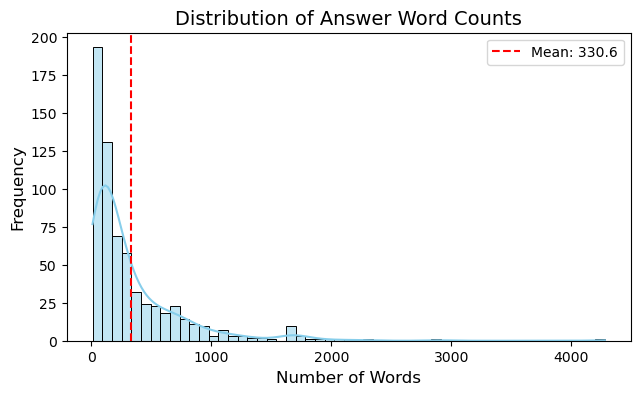

In [11]:
# Visualize the distribution of word counts
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
sns.histplot(medquad_df['answer_word_count'], kde=True, color='skyblue')
plt.title('Distribution of Answer Word Counts', fontsize=14)
plt.xlabel('Number of Words', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.axvline(x=answer_length_stats['answer_word_count']['mean'], 
            color='red', linestyle='--', label=f"Mean: {answer_length_stats['answer_word_count']['mean']:.1f}")
plt.legend()
plt.show()

Finally, we have to encode target groups.

In [12]:
focus_map = {"Neurological & Cognitive Disorders":0,
             "Cancers":1,
             "Cardiovascular Diseases":2,
             "Metabolic & Endocrine Disorders":3,
             "Other Age-Related & Immune Disorders":4}

medquad_df['focus_group'] = medquad_df['focus_group'].replace(focus_map)

In [13]:
# Returns all rows that are duplicates of a previous row
print("Shape before duplicates:", medquad_df.shape)
duplicates = medquad_df[medquad_df.duplicated(subset='answer')]
medquad_df = medquad_df.drop_duplicates(subset='answer')
print("Shape after removing duplicates:", medquad_df.shape)

Shape before duplicates: (647, 7)
Shape after removing duplicates: (624, 7)


#### Split to train and test datasets

In [14]:
train_df, test_df = train_test_split(medquad_df,
                                     test_size=0.2,
                                     random_state=42,
                                     stratify=medquad_df['focus_group'])

In [15]:
print("Training set distribution:", train_df['focus_group'].value_counts(1))
print("Testing set distribution:", test_df['focus_group'].value_counts(1))

Training set distribution: focus_group
1    0.334669
2    0.234469
4    0.186373
3    0.130261
0    0.114228
Name: proportion, dtype: float64
Testing set distribution: focus_group
1    0.336
2    0.232
4    0.184
3    0.136
0    0.112
Name: proportion, dtype: float64


#### Create Training Corpus

In [16]:
train_texts = train_df['answer'].tolist()
train_labels = train_df['focus_group'].tolist()

#### Tokenizing

Before tokenization we remove key words in the texts to prevent data leakage or, at least, to prevent aiming model to finding keywords instead of analysing entire text.

In [17]:
remove_keywords = [
    'Breast Cancer', 'Prostate Cancer', 'Skin Cancer',
    'Colorectal Cancer', 'Lung Cancer', 'Leukemia', 'Stroke', 'Heart Failure', 'Heart Attack',
    'High Blood Cholesterol', 'High Blood Pressure', 'Causes of Diabetes', 'Diabetes', 'Diabetic Retinopathy',
    'Hemochromatosis', 'Kidney Disease', 'Alzheimer\'s Disease', 'Parkinson\'s Disease', 'Balance Problems',
    'Shingles', 'Osteoporosis', 'Age-related Macular Degeneration',
    'Psoriasis', 'Gum (Periodontal) Disease', 'Dry Mouth'
]

# Split all multi-word phrases into individual words 
# Ex. "High Blood Cholesterol" ==> "High", "Blood", "Cholesterol"
words_to_remove = set()
for phrase in remove_keywords:
    for word in re.findall(r'\b\w+\b', phrase):
        words_to_remove.add(word.lower())  # lowercased for case-insensitive match

# Create regex pattern to match any of the words
pattern = re.compile(r'\b(?:' + '|'.join(map(re.escape, words_to_remove)) + r')\b', flags=re.IGNORECASE)

# Remove individual words from each text
masked_train_texts = [pattern.sub('', text) for text in train_texts]

# Normalize whitespace
masked_train_texts = [re.sub(r'\s+', ' ', text).strip() for text in masked_train_texts]

In [18]:
def tokenize(text):
    tokenized_text = re.findall(r'\b\w+\b', text.lower())
    return tokenized_text

tokenized_training_corpus = [tokenize(focus_area_text) for focus_area_text in masked_train_texts]

#### Create Vocabulary

In [19]:
combined_training_corpus = []
for text in tokenized_training_corpus:
    for token in text:
        combined_training_corpus.append(token)

word_freqs = Counter(combined_training_corpus)

In [20]:
MAX_VOCAB_SIZE = 1000
most_common_words = word_freqs.most_common(MAX_VOCAB_SIZE)
print("Top 10 Most Common Words: ", most_common_words[0:10])

Top 10 Most Common Words:  [('the', 7750), ('to', 3886), ('and', 3786), ('a', 3469), ('in', 2694), ('or', 2666), ('is', 2301), ('are', 1643), ('for', 1537), ('your', 1523)]


In [21]:
vocab = {word: idx + 2 for idx, (word, freq) in enumerate(most_common_words)}
vocab['<unk>'] = 0
vocab['<pad>'] = 1 

#### Encoding Text

In [22]:
def encode_text(text, vocab):
    tokenized_text = tokenize(text)
    encoded_text = [vocab.get(word, vocab['<unk>']) for word in tokenized_text]
    return encoded_text

def pad_or_truncate(encoded_text, max_len):
    if len(encoded_text) > max_len:
        return encoded_text[:max_len]
    else:
        return encoded_text + [vocab['<pad>']] * (max_len - len(encoded_text)) 

In [23]:
MAX_SEQ_LENGTH = 128
padded_train_seqs = [pad_or_truncate(encode_text(seq, vocab), max_len=MAX_SEQ_LENGTH) for seq in train_texts]

#### Convert to Tensors

In [24]:
X_train_tensor = torch.tensor(padded_train_seqs)
y_train_tensor = torch.tensor(train_labels, dtype=torch.long)

batch_size = 16
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

## Model 1 - FeedForward NN

### Build the Neural Network Architecture

In [25]:
torch.manual_seed(42)

class FeedForwardNNWithEmbedding(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size1, hidden_size2, output_size):
        super(FeedForwardNNWithEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)

        self.fc1 = nn.Linear(embed_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)

        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        
        self.output = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        x = self.embedding(x)
        x = torch.mean(x, dim=1)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.output(x)
        return x
    
# Initialize loss function + optimizer
vocab_size = len(vocab)
embed_size = 50 
hidden_size1 = 128
hidden_size2 = 64
output_size = n_focus_groups

model = FeedForwardNNWithEmbedding(vocab_size, embed_size, hidden_size1, hidden_size2, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

### Training Loop

In [26]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=5):
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            output = model(batch_X)
            loss = criterion(output, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        if (epoch + 1) % 100 == 0:
            print(f"[Epoch {epoch + 1}/{num_epochs}], Average CE Loss: {avg_loss:.10f}")

# Train the model
train_model(model, train_dataloader, criterion, optimizer, num_epochs=500)

[Epoch 100/500], Average CE Loss: 1.0386927351
[Epoch 200/500], Average CE Loss: 0.6570144445
[Epoch 300/500], Average CE Loss: 0.3309075059
[Epoch 400/500], Average CE Loss: 0.1605443320
[Epoch 500/500], Average CE Loss: 0.0581878474


### Testing Set Evaluation

In [27]:
# Convert the testing texts and labels to lists
test_texts = test_df['answer'].tolist()
test_labels = test_df['focus_group'].tolist()

# Encode and pad/truncate the testing sequences
padded_test_seqs = [pad_or_truncate(encode_text(seq, vocab), MAX_SEQ_LENGTH) for seq in test_texts]

# Convert testing sequences to tensors
X_tensor_test = torch.tensor(padded_test_seqs)
y_tensor_test = torch.tensor(test_labels, dtype=torch.long)

# Batch the testing set
test_dataset = TensorDataset(X_tensor_test, y_tensor_test)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [28]:
def get_predictions_and_probabilities(model, test_loader):
    model.eval()

    all_probs = [] 
    all_labels = []

    with torch.no_grad(): 
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            probs = F.softmax(outputs, dim=1)  
            all_probs.extend(probs.cpu().numpy())
            predicted_labels = torch.argmax(outputs, dim=1)
            all_labels.extend(predicted_labels.cpu().numpy())

    return all_probs, all_labels

# Generate predictions
nn_pred_probs, nn_pred_labels = get_predictions_and_probabilities(model, test_loader)

In [29]:
focus_group_names = ["Neurological & Cognitive Disorders", "Cancers", "Cardiovascular Diseases", 
                     "Metabolic & Endocrine Disorders", "Other Age-Related & Immune Disorders"]

conf_matrix = confusion_matrix(test_labels, nn_pred_labels)
report = classification_report(test_labels, nn_pred_labels, target_names=focus_group_names)

print(conf_matrix)
print(report)

[[11  1  1  0  1]
 [ 1 38  0  0  3]
 [ 1  1 22  2  3]
 [ 0  0  4  9  4]
 [ 1  0  2  0 20]]
                                      precision    recall  f1-score   support

  Neurological & Cognitive Disorders       0.79      0.79      0.79        14
                             Cancers       0.95      0.90      0.93        42
             Cardiovascular Diseases       0.76      0.76      0.76        29
     Metabolic & Endocrine Disorders       0.82      0.53      0.64        17
Other Age-Related & Immune Disorders       0.65      0.87      0.74        23

                            accuracy                           0.80       125
                           macro avg       0.79      0.77      0.77       125
                        weighted avg       0.81      0.80      0.80       125



### Key Insights

The feedforward neural network with embeddings achieved moderate classification accuracy (0.8) across the five medical focus groups. The confusion matrix and classification report indicate that some groups are easier to distinguish than others, likely due to overlapping terminology and class imbalance. Overall, the model demonstrates the feasibility of automated medical text classification, but further improvements—such as balancing the dataset, refining preprocessing, or using more advanced architectures—could enhance performance.

## Model 2 - Fine-tuned BERT Transformer

### Load the pre-trained model

In [30]:
# Load BiomedBERT model and tokenizer
model_name = "microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext"
bert_tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=n_focus_groups)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

c:\Users\Egor.Tykmanov\AppData\Local\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Egor.Tykmanov\.cache\huggingface\hub\models--microsoft--BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [31]:
# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
bert_model = bert_model.to(device)

Using device: cpu


### Freeze and unfreeze layers

In [ ]:
# Inspect architecture
for name, param in bert_model.named_parameters():
    print(f"Layer: {name} | Shape: {param.shape} | Requires Grad: {param.requires_grad}")

Layer: bert.embeddings.word_embeddings.weight | Shape: torch.Size([30522, 768]) | Requires Grad: True
Layer: bert.embeddings.position_embeddings.weight | Shape: torch.Size([512, 768]) | Requires Grad: True
Layer: bert.embeddings.token_type_embeddings.weight | Shape: torch.Size([2, 768]) | Requires Grad: True
Layer: bert.embeddings.LayerNorm.weight | Shape: torch.Size([768]) | Requires Grad: True
Layer: bert.embeddings.LayerNorm.bias | Shape: torch.Size([768]) | Requires Grad: True
Layer: bert.encoder.layer.0.attention.self.query.weight | Shape: torch.Size([768, 768]) | Requires Grad: True
Layer: bert.encoder.layer.0.attention.self.query.bias | Shape: torch.Size([768]) | Requires Grad: True
Layer: bert.encoder.layer.0.attention.self.key.weight | Shape: torch.Size([768, 768]) | Requires Grad: True
Layer: bert.encoder.layer.0.attention.self.key.bias | Shape: torch.Size([768]) | Requires Grad: True
Layer: bert.encoder.layer.0.attention.self.value.weight | Shape: torch.Size([768, 768]) | Re

In [34]:
# Freeze all layers
for param in bert_model.bert.parameters():
    param.requires_grad = False
# Unfreeze the classifier layer
for param in bert_model.classifier.parameters():
    param.requires_grad = True
# Unfreeze the pooler layer
for param in bert_model.bert.pooler.parameters():
    param.requires_grad = True
# Unfreeze the last 3 layers of the encoder (layers 9-11)
for i in range(9, 12):
    for param in bert_model.bert.encoder.layer[i].parameters():
        param.requires_grad = True

### Tokenizing

In [35]:
MAX_SEQ_LENGTH = 512

X_train = bert_tokenizer(masked_train_texts, padding=True, truncation=True, return_tensors="pt", max_length=MAX_SEQ_LENGTH)
y_train = torch.tensor(train_labels, dtype=torch.long)

train_dataset = TensorDataset(
    X_train['input_ids'].to(device), 
    X_train['attention_mask'].to(device), 
    y_train.to(device)
)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

### Fine-Tuning Loop

In [36]:
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, bert_model.parameters()), 
                              lr=0.00001)
criterion = nn.CrossEntropyLoss()

In [37]:
num_epochs = 10
for epoch in range(num_epochs):
    bert_model.train()
    total_loss = 0.0
    
    for batch_X, batch_attention_mask, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = bert_model(input_ids=batch_X, 
                                     attention_mask=batch_attention_mask)
        logits = outputs.logits
        loss = criterion(logits, batch_y)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    avg_loss = total_loss / len(train_loader)
    if (epoch + 1) % 1 == 0:
        print(f'Epoch {epoch+1}, Average CE Loss: {avg_loss}')

Epoch 1, Average CE Loss: 1.5691405273973942
Epoch 2, Average CE Loss: 1.4481211081147194
Epoch 3, Average CE Loss: 1.3312761299312115
Epoch 4, Average CE Loss: 1.046698346734047
Epoch 5, Average CE Loss: 0.6922806915827096
Epoch 6, Average CE Loss: 0.4616279462352395
Epoch 7, Average CE Loss: 0.3416350884363055
Epoch 8, Average CE Loss: 0.2845331118442118
Epoch 9, Average CE Loss: 0.18814481468871236
Epoch 10, Average CE Loss: 0.15574884973466396


### Testing Set Evaluation

In [38]:
# Tokenize and convert to tensors
X_test = bert_tokenizer(test_texts, padding=True, truncation=True, return_tensors="pt", max_length=MAX_SEQ_LENGTH)
y_test = torch.tensor(test_labels, dtype=torch.long)

# Batch the testing set
from torch.utils.data import DataLoader, TensorDataset
test_dataset = TensorDataset(X_test['input_ids'].to(device), 
                             X_test['attention_mask'].to(device),
                             y_test.to(device))
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [39]:
bert_model.eval()
bert_pred_probs = []
bert_pred_labels = []

with torch.no_grad():
    for batch_X, batch_attention_mask, batch_y in test_loader:
        outputs = bert_model(input_ids= batch_X, 
                                   attention_mask= batch_attention_mask)
        logits = outputs.logits
        probs = F.softmax(logits, dim=1)
        bert_pred_probs.extend(probs.cpu().numpy())
        
        predicted_labels = torch.argmax(logits, dim=1)
        bert_pred_labels.extend(predicted_labels.cpu().numpy())

In [40]:
focus_group_names = ["Neurological & Cognitive Disorders", "Cancers", "Cardiovascular Diseases", 
                     "Metabolic & Endocrine Disorders", "Other Age-Related & Immune Disorders"]

confusion_matrix = confusion_matrix(test_labels, bert_pred_labels)
report = classification_report(test_labels, bert_pred_labels, target_names=focus_group_names)

print(confusion_matrix)
print(report)

[[14  0  0  0  0]
 [ 0 41  0  0  1]
 [ 0  0 29  0  0]
 [ 0  0  1 16  0]
 [ 0  0  0  0 23]]
                                      precision    recall  f1-score   support

  Neurological & Cognitive Disorders       1.00      1.00      1.00        14
                             Cancers       1.00      0.98      0.99        42
             Cardiovascular Diseases       0.97      1.00      0.98        29
     Metabolic & Endocrine Disorders       1.00      0.94      0.97        17
Other Age-Related & Immune Disorders       0.96      1.00      0.98        23

                            accuracy                           0.98       125
                           macro avg       0.98      0.98      0.98       125
                        weighted avg       0.98      0.98      0.98       125



### Key Insights

The fine-tuned specialized BiomedBERT significantly outperforms the simple neural network, achieving nearly perfect classification scores across all classes in each key metric!

## Conclusion

In conclusion, in this project, two models were implemented, trained for task classification medical text. The first model is the FeedForward NN With Embeddings, which gave moderate results. The second model is a fine-tuned model based on the pre-trained BERT Transformer. Having a lot complicated architecture and demanding much more computational resources, the second model totally outperformed simple NN and gave almost perfect results.